# Regularization

## Why Regularize?

In an attempt to fit a good model to data, we often tend to overfit. Regularization discourages overly complex models by penalizing the loss function.

### The Bias-Variance Tradeoff

When we did Linear Regression, we briefly talked about the Bias-Variance Tradeoff.

![](http://scott.fortmann-roe.com/docs/docs/BiasVariance/biasvariance.png)

![](https://miro.medium.com/max/544/1*Y-yJiR0FzMgchPA-Fm5c1Q.jpeg)

**High bias** 

 - Systematic error in predictions (i.e. the average)
 - Bias is about the strength of assumptions the model makes
 - Underfit models tend to have high bias


**High variance**

 - The model is highly sensitive to changes in the data
 - Overfit models tend to have low bias and high variance
    
    
![](https://gblobscdn.gitbook.com/assets%2F-LvBP1svpACTB1R1x_U4%2F-LvNWUoWieQqaGmU_gl9%2F-LvNoby-llz4QzAK15nL%2Fimage.png?alt=media&token=41720ce9-bb66-4419-9bd8-640abf1fc415)

 - Underfit Models fail to capture all of the information in the data
 - Overfit models fit to the noise in the data and fail to generalize


**How would we know if our model is over or underfit?**
 - Train test split & look at the testing error
 - As model complexity increases so does the possibility for overfitting

## Ridge and Lasso

Ridge and Lasso regression are two examples of penalized estimation. Penalized estimation makes some or all of the coefficients smaller in magnitude (closer to zero). Some of the penalties have the property of performing both variable selection (setting some coefficients exactly equal to zero) and shrinking the other coefficients. 

In Ridge regression, the cost function is changed by adding a penalty term to the square of the magnitude of the coefficients. 

$$ \text{cost_function_ridge}= \sum_{i=1}^n(y_i - \hat{y})^2 = \sum_{i=1}^n(y_i - \sum_{j=1}^k(m_jx_{ij})-b)^2 + \lambda \sum_{j=1}^p m_j^2$$

Lasso regression (Least Absolute Shrinkage and Selection Operator) is very similar to Ridge regression, except that the magnitude of the coefficients are not squared in the penalty term.

$$ \text{cost_function_lasso}= \sum_{i=1}^n(y_i - \hat{y})^2 = \sum_{i=1}^n(y_i - \sum_{j=1}^k(m_jx_{ij})-b)^2 + \lambda \sum_{j=1}^p \mid m_j \mid$$

So we're penalizing large coefficients -- what are the effects/implications of that?

### Standardization before Regularization

An important step before using either Lasso or Ridge regularization is to first standardize your data such that it is all on the same scale. Regularization is based on the concept of penalizing larger coefficients, so **if you have features that are on different scales, some will get unfairly penalized**. A downside of standardization is that the value of the coefficients become less interpretable and must be transformed back to their original scale if you want to interpret how a one unit change in a feature impacts the target variable.

**Scaler documentation:**

* https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html
* https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html

## Let's Code! 

Start with a regular Linear Regression.

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import OneHotEncoder

# import warnings
# warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('data/ames_train.csv') # Ames housing data

# Drop sale detail columns 
df = df.drop(columns = ['Id', 'MoSold', 'YrSold', 'SaleType', 'SaleCondition'])

# Create X and y
y = df['SalePrice']
X = df.drop(columns=['SalePrice'], axis=1)

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

### Time to Clean/Process

In [3]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1095 entries, 1023 to 1126
Data columns (total 75 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1095 non-null   int64  
 1   MSZoning       1095 non-null   object 
 2   LotFrontage    895 non-null    float64
 3   LotArea        1095 non-null   int64  
 4   Street         1095 non-null   object 
 5   Alley          70 non-null     object 
 6   LotShape       1095 non-null   object 
 7   LandContour    1095 non-null   object 
 8   Utilities      1095 non-null   object 
 9   LotConfig      1095 non-null   object 
 10  LandSlope      1095 non-null   object 
 11  Neighborhood   1095 non-null   object 
 12  Condition1     1095 non-null   object 
 13  Condition2     1095 non-null   object 
 14  BldgType       1095 non-null   object 
 15  HouseStyle     1095 non-null   object 
 16  OverallQual    1095 non-null   int64  
 17  OverallCond    1095 non-null   int64  
 18  YearB

In [4]:
# Let's check the percentage of our training data that's null per column
null_perc = X_train.isna().sum() / len(X_train)
null_perc.sort_values(ascending=False).head(20)

PoolQC          0.994521
MiscFeature     0.960731
Alley           0.936073
Fence           0.800913
FireplaceQu     0.467580
LotFrontage     0.182648
GarageQual      0.052968
GarageType      0.052968
GarageYrBlt     0.052968
GarageFinish    0.052968
GarageCond      0.052968
BsmtCond        0.024658
BsmtExposure    0.024658
BsmtFinType2    0.024658
BsmtQual        0.024658
BsmtFinType1    0.024658
MasVnrArea      0.003653
MasVnrType      0.003653
Electrical      0.000913
YearRemodAdd    0.000000
dtype: float64

In [5]:
# Drop where nulls are more than 10% of column
null_cols = list(null_perc[null_perc > .1].index)
print(null_cols)

X_train = X_train.drop(columns=null_cols, axis=1)
X_test = X_test.drop(columns=null_cols, axis=1)

['LotFrontage', 'Alley', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature']


In [6]:
# Start with the continuous variables

# Grab only numeric features
cont_features = [col for col in X_train.columns if X_train[col].dtype in [np.float64, np.int64]]

X_train_cont = X_train[cont_features]
X_test_cont = X_test[cont_features]

# Impute missing values with 0 using SimpleImputer
# (most columns look like they just don't have details)
impute = SimpleImputer(strategy='constant', fill_value=0) 
X_train_imputed = impute.fit_transform(X_train_cont)
X_test_imputed = impute.transform(X_test_cont) 

# Scale the train and test data
scaler = StandardScaler()
X_train_imputed_scaled = scaler.fit_transform(X_train_imputed)
X_test_imputed_scaled = scaler.transform(X_test_imputed)

In [7]:
# Now time for the categorical columns

# Create X_cat which contains only the categorical variables
features_cat = [col for col in X_train.columns if X_train[col].dtype in [np.object]]
X_train_cat = X_train[features_cat]
X_test_cat = X_test[features_cat]

# Fill missing values with the string 'missing'
X_train_cat.fillna(value='missing', inplace=True)
X_test_cat.fillna(value='missing', inplace=True)

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/frame.py:4317: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


In [8]:
# Exploring column percentages

# Let's remove any column where the most common value is more than 90% of that col
cols_to_remove = []
for col in X_train_cat.columns:
    col_series = X_train_cat[col].value_counts()
    display(col_series /len(X_train_cat)) # percentages

    if col_series[0]/len(X_train_cat) > .9:
        print(f"You should remove {col}")
        cols_to_remove.append(col)

RL         0.790868
RM         0.149772
FV         0.042922
RH         0.012785
C (all)    0.003653
Name: MSZoning, dtype: float64

Pave    0.996347
Grvl    0.003653
Name: Street, dtype: float64

You should remove Street


Reg    0.621918
IR1    0.338813
IR2    0.031963
IR3    0.007306
Name: LotShape, dtype: float64

Lvl    0.905936
Bnk    0.041096
HLS    0.029224
Low    0.023744
Name: LandContour, dtype: float64

You should remove LandContour


AllPub    0.999087
NoSeWa    0.000913
Name: Utilities, dtype: float64

You should remove Utilities


Inside     0.699543
Corner     0.190868
CulDSac    0.073059
FR2        0.033790
FR3        0.002740
Name: LotConfig, dtype: float64

Gtl    0.946119
Mod    0.045662
Sev    0.008219
Name: LandSlope, dtype: float64

You should remove LandSlope


NAmes      0.152511
CollgCr    0.102283
OldTown    0.079452
Edwards    0.075799
Somerst    0.056621
NWAmes     0.054795
Gilbert    0.053881
NridgHt    0.052968
Sawyer     0.046575
BrkSide    0.040183
SawyerW    0.036530
Crawfor    0.035616
Mitchel    0.034703
NoRidge    0.028311
Timber     0.024658
IDOTRR     0.022831
StoneBr    0.018265
ClearCr    0.017352
SWISU      0.016438
Blmngtn    0.013699
BrDale     0.011872
MeadowV    0.009132
Veenker    0.008219
NPkVill    0.006393
Blueste    0.000913
Name: Neighborhood, dtype: float64

Norm      0.863927
Feedr     0.053881
Artery    0.033790
RRAn      0.015525
PosN      0.012785
RRAe      0.009132
PosA      0.005479
RRNn      0.004566
RRNe      0.000913
Name: Condition1, dtype: float64

Norm      0.991781
Feedr     0.002740
PosN      0.001826
Artery    0.001826
RRAe      0.000913
RRAn      0.000913
Name: Condition2, dtype: float64

You should remove Condition2


1Fam      0.835616
TwnhsE    0.076712
Duplex    0.033790
Twnhs     0.029224
2fmCon    0.024658
Name: BldgType, dtype: float64

1Story    0.494064
2Story    0.309589
1.5Fin    0.104110
SLvl      0.045662
SFoyer    0.021005
1.5Unf    0.010046
2.5Unf    0.009132
2.5Fin    0.006393
Name: HouseStyle, dtype: float64

Gable      0.769863
Hip        0.205479
Flat       0.010046
Gambrel    0.008219
Mansard    0.004566
Shed       0.001826
Name: RoofStyle, dtype: float64

CompShg    0.982648
Tar&Grv    0.008219
WdShngl    0.003653
WdShake    0.002740
ClyTile    0.000913
Metal      0.000913
Roll       0.000913
Name: RoofMatl, dtype: float64

You should remove RoofMatl


VinylSd    0.359817
HdBoard    0.152511
MetalSd    0.146119
Wd Sdng    0.145205
Plywood    0.068493
CemntBd    0.038356
BrkFace    0.034703
WdShing    0.017352
Stucco     0.017352
AsbShng    0.014612
BrkComm    0.001826
CBlock     0.000913
ImStucc    0.000913
AsphShn    0.000913
Stone      0.000913
Name: Exterior1st, dtype: float64

VinylSd    0.351598
Wd Sdng    0.140639
HdBoard    0.140639
MetalSd    0.139726
Plywood    0.094064
CmentBd    0.037443
Wd Shng    0.029224
Stucco     0.019178
AsbShng    0.015525
BrkFace    0.013699
ImStucc    0.005479
Brk Cmn    0.005479
AsphShn    0.002740
Stone      0.002740
CBlock     0.000913
Other      0.000913
Name: Exterior2nd, dtype: float64

None       0.579909
BrkFace    0.315068
Stone      0.090411
BrkCmn     0.010959
missing    0.003653
Name: MasVnrType, dtype: float64

TA    0.622831
Gd    0.331507
Ex    0.035616
Fa    0.010046
Name: ExterQual, dtype: float64

TA    0.876712
Gd    0.098630
Fa    0.021918
Ex    0.001826
Po    0.000913
Name: ExterCond, dtype: float64

PConc     0.449315
CBlock    0.427397
BrkTil    0.098630
Slab      0.017352
Stone     0.004566
Wood      0.002740
Name: Foundation, dtype: float64

TA         0.442922
Gd         0.421005
Ex         0.085845
Fa         0.025571
missing    0.024658
Name: BsmtQual, dtype: float64

TA         0.892237
Gd         0.047489
Fa         0.034703
missing    0.024658
Po         0.000913
Name: BsmtCond, dtype: float64

No         0.656621
Av         0.148858
Gd         0.089498
Mn         0.080365
missing    0.024658
Name: BsmtExposure, dtype: float64

Unf        0.287671
GLQ        0.285845
ALQ        0.155251
BLQ        0.102283
Rec        0.092237
LwQ        0.052055
missing    0.024658
Name: BsmtFinType1, dtype: float64

Unf        0.863927
Rec        0.038356
LwQ        0.030137
missing    0.024658
BLQ        0.018265
ALQ        0.015525
GLQ        0.009132
Name: BsmtFinType2, dtype: float64

GasA     0.977169
GasW     0.013699
Grav     0.003653
Wall     0.002740
OthW     0.001826
Floor    0.000913
Name: Heating, dtype: float64

You should remove Heating


Ex    0.506849
TA    0.291324
Gd    0.165297
Fa    0.035616
Po    0.000913
Name: HeatingQC, dtype: float64

Y    0.928767
N    0.071233
Name: CentralAir, dtype: float64

You should remove CentralAir


SBrkr      0.915068
FuseA      0.060274
FuseF      0.021005
FuseP      0.002740
missing    0.000913
Name: Electrical, dtype: float64

You should remove Electrical


TA    0.502283
Gd    0.401826
Ex    0.066667
Fa    0.029224
Name: KitchenQual, dtype: float64

Typ     0.925114
Min2    0.025571
Min1    0.024658
Mod     0.011872
Maj1    0.008219
Maj2    0.003653
Sev     0.000913
Name: Functional, dtype: float64

You should remove Functional


Attchd     0.594521
Detchd     0.263927
BuiltIn    0.063014
missing    0.052968
Basment    0.013699
CarPort    0.006393
2Types     0.005479
Name: GarageType, dtype: float64

Unf        0.410046
RFn        0.293151
Fin        0.243836
missing    0.052968
Name: GarageFinish, dtype: float64

TA         0.900457
missing    0.052968
Fa         0.031963
Gd         0.010959
Ex         0.002740
Po         0.000913
Name: GarageQual, dtype: float64

You should remove GarageQual


TA         0.908676
missing    0.052968
Fa         0.024658
Gd         0.008219
Po         0.003653
Ex         0.001826
Name: GarageCond, dtype: float64

You should remove GarageCond


Y    0.916895
N    0.061187
P    0.021918
Name: PavedDrive, dtype: float64

You should remove PavedDrive


In [9]:
# Now drop those
X_train_cat = X_train_cat.drop(columns=cols_to_remove, axis=1)
X_test_cat = X_test_cat.drop(columns=cols_to_remove, axis=1)

In [10]:
# OneHotEncode categorical variables
ohe = OneHotEncoder(handle_unknown='ignore')

X_train_ohe = ohe.fit_transform(X_train_cat)
X_test_ohe = ohe.transform(X_test_cat)

# Convert these columns into a DataFrame 
ohe_col_names = ohe.get_feature_names(input_features=X_train_cat.columns)
cat_train_df = pd.DataFrame(X_train_ohe.todense(), columns=ohe_col_names)
cat_test_df = pd.DataFrame(X_test_ohe.todense(), columns=ohe_col_names)

In [14]:
# Put it all back together
X_train_all = pd.concat([pd.DataFrame(X_train_imputed_scaled), cat_train_df], axis=1)
X_test_all = pd.concat([pd.DataFrame(X_test_imputed_scaled), cat_test_df], axis=1)

# Fit the model
linreg = LinearRegression()
linreg.fit(X_train_all, y_train)

LinearRegression()

In [12]:
# Write a quick evaluation function

def evaluate(train_actual, train_predicted, test_actual, test_predicted):
    '''
    Takes in both actual and predicted values, for the train and test set
    Then prints the scores based on those values
    
    Inputs:
    -------
    train_actual - actual target values for the train set
    train_predicted - predicted target values for the train set
    test_actual - actual target values for the test set
    test_predicted - predicted target values for the test set
    '''
    print('Train R2:', r2_score(train_actual, train_predicted))
    print('Test R2:', r2_score(test_actual, test_predicted))
    print("*****")
    print('Train MSE:', mean_squared_error(train_actual, train_predicted))
    print('Test MSE:', mean_squared_error(test_actual, test_predicted))
    print("*****")
    print('Train RMSE:', mean_squared_error(train_actual, train_predicted, squared=False))
    print('Test RMSE:', mean_squared_error(test_actual, test_predicted, squared=False))

In [15]:
# Grab predictions and evaluate
train_preds = linreg.predict(X_train_all)
test_preds = linreg.predict(X_test_all)

evaluate(y_train, train_preds, y_test, test_preds)

Train R2: 0.8902048547244455
Test R2: -8.575852570618839e+17
*****
Train MSE: 666615200.151493
Test MSE: 6.007649764448358e+27
*****
Train RMSE: 25818.892310699408
Test RMSE: 77509030212281.45


In [16]:
residuals_train = y_train - train_preds
residuals_test = y_test - test_preds

Text(0.5, 0, 'Predicted Values')

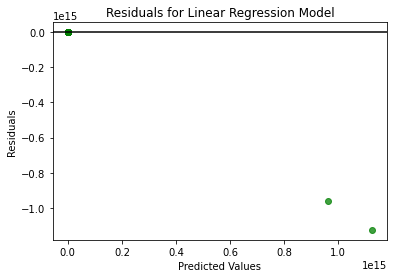

In [17]:
plt.scatter(train_preds, residuals_train, alpha=.75)
plt.scatter(test_preds, residuals_test, color='g', alpha=.75)

plt.axhline(y=0, color='black')

plt.title('Residuals for Linear Regression Model')
plt.ylabel('Residuals')
plt.xlabel('Predicted Values')

In [18]:
linreg.coef_

array([ 6.36871425e+03,  3.58286634e+03,  1.12682881e+04,  5.68492113e+03,
        5.92470174e+03,  2.08903523e+03,  5.71046052e+02, -8.17220082e+15,
       -2.74661917e+15, -7.93959852e+15,  7.92200064e+15, -2.79172603e+16,
       -3.18005799e+16, -3.53259344e+15,  3.80376535e+16,  4.26731035e+03,
        2.37151115e+01,  5.26843727e+03,  2.04949117e+03, -8.36552161e+02,
       -3.90452316e+03,  5.38746384e+03,  3.76136896e+03, -4.50027245e+03,
        9.62186715e+03,  8.47817565e+01,  2.83465435e+03, -5.24108798e+02,
        9.89561769e+02,  2.26477071e+03,  2.52946581e+03,  3.42033184e+02,
       -1.10142957e+03,  2.07159378e+15,  2.07159378e+15,  2.07159378e+15,
        2.07159378e+15,  2.07159378e+15, -3.25783572e+14, -3.25783572e+14,
       -3.25783572e+14, -3.25783572e+14,  6.81010486e+14,  6.81010486e+14,
        6.81010486e+14,  6.81010486e+14,  6.81010486e+14, -4.93415429e+14,
       -4.93415429e+14, -4.93415429e+14, -4.93415429e+14, -4.93415429e+14,
       -4.93415429e+14, -

In [22]:
# Explore coefficients
print(f"Intercept: {linreg.intercept_}")

cols = [*X_train_cont.columns, *ohe_col_names]
coefs = pd.Series(linreg.coef_, index= cols)
display(coefs.sort_values(ascending=False))

Intercept: -61538967572900.27


GrLivArea               3.803765e+16
TotalBsmtSF             7.922001e+15
GarageFinish_missing    4.263832e+15
GarageType_Basment      2.318320e+15
GarageType_Detchd       2.318320e+15
                            ...     
LowQualFinSF           -3.532593e+15
BsmtUnfSF              -7.939599e+15
BsmtFinSF1             -8.172201e+15
1stFlrSF               -2.791726e+16
2ndFlrSF               -3.180058e+16
Length: 200, dtype: float64

In [23]:
print("Total number of coefficients: ", len(linreg.coef_))
print("Coefficients close to zero: ", sum(abs(linreg.coef_) < 10**(-10)))

Total number of coefficients:  200
Coefficients close to zero:  0


**Evaluate**

- 


In [24]:
# Let's wrap up that coefficient exploration in a function

def eval_coefficients(model, column_names):
    '''
    Prints an exploration 
    
    Inputs:
    model - a fit linear model (sklearn)
    column_names - a list of feature names that matches the order passed into the model
    
    Outputs:
    coefs - a Series, sorted by coefficient value
    '''

    print("Total number of coefficients: ", len(model.coef_))
    print("Coefficients close to zero: ", sum(abs(model.coef_) < 10**(-10)))
    print(f"Intercept: {model.intercept_}")
    
    coefs = pd.Series(model.coef_, index= column_names)
    display(coefs.sort_values(ascending=False))
    return coefs.sort_values(ascending=False)

## Fitting Ridge and Lasso

* https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html
* https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html

### LASSO

In [25]:
from sklearn.linear_model import Lasso

lasso = Lasso() # Lasso is also known as the L1 norm 
lasso.fit(X_train_imputed_scaled, y_train)

lasso_train_preds = lasso.predict(X_train_imputed_scaled)
lasso_test_preds = lasso.predict(X_test_imputed_scaled)

evaluate(y_train, lasso_train_preds, y_test, lasso_test_preds)

Train R2: 0.8068837772699294
Test R2: 0.8310540526127361
*****
Train MSE: 1172494550.1426334
Test MSE: 1183518574.588042
*****
Train RMSE: 34241.70775739191
Test RMSE: 34402.304785988425


In [28]:
lasso_v2 = Lasso(alpha=10) # adjusting HYPERPARAMETERS -- check documentation!
lasso_v2.fit(X_train_all, y_train)

lasso_train_preds_v2 = lasso_v2.predict(X_train_all)
lasso_test_preds_v2 = lasso_v2.predict(X_test_all)

evaluate(y_train, lasso_train_preds_v2, y_test, lasso_test_preds_v2)

Train R2: 0.8897762191436047
Test R2: 0.8664340095251808
*****
Train MSE: 669217637.5616094
Test MSE: 935671042.1579182
*****
Train RMSE: 25869.24114777257
Test RMSE: 30588.740447392047


In [30]:
# Check Lasso Coefficients

lasso_v2_coefs = eval_coefficients(lasso_v2, cols)

Total number of coefficients:  200
Coefficients close to zero:  43
Intercept: 146759.36027736007


Neighborhood_StoneBr    57157.492559
Exterior2nd_ImStucc     55679.078169
Neighborhood_NoRidge    44416.754415
Neighborhood_NridgHt    33752.371368
BsmtQual_Ex             29560.086961
                            ...     
LotConfig_FR3          -19966.752901
BldgType_TwnhsE        -21606.119697
BldgType_Twnhs         -25148.112954
LotShape_IR3           -32951.670440
Exterior1st_ImStucc    -54391.221289
Length: 200, dtype: float64

### Ridge

In [32]:
from sklearn.linear_model import Ridge

ridge = Ridge(alpha=10) # Ridge is also known as the L2 norm
ridge.fit(X_train_all, y_train)

ridge_train_preds = ridge.predict(X_train_all)
ridge_test_preds = ridge.predict(X_test_all)

evaluate(y_train, ridge_train_preds, y_test, ridge_test_preds)

Train R2: 0.883048000456683
Test R2: 0.8760128192381831
*****
Train MSE: 710067648.1462206
Test MSE: 868568519.7647879
*****
Train RMSE: 26647.094553557254
Test RMSE: 29471.486555055006


In [33]:
# Check Ridge Coefficients

ridge_coefs = eval_coefficients(ridge, cols)

Total number of coefficients:  200
Coefficients close to zero:  0
Intercept: 175399.39871730757


Neighborhood_StoneBr    27849.943941
Neighborhood_NoRidge    26235.823769
BsmtQual_Ex             20035.972464
KitchenQual_Ex          17702.579533
Neighborhood_NridgHt    17238.299997
                            ...     
Neighborhood_Gilbert    -9310.450038
HouseStyle_2Story       -9968.806704
Neighborhood_Mitchel   -13108.277113
LotShape_IR3           -14914.301134
Neighborhood_Edwards   -16224.917892
Length: 200, dtype: float64

### Let's Discuss

- 


## Ridge & Lasso: Other benefits

### Ridge:
* We can "shrink down" prediction variables effects instead of deleting/zeroing them
* When you have features with high multicollinearity, the coefficients are automatically spread across them (you won't have redundancy)
* Since includes all features it can be computationally expensive (for many variables)

### Lasso:
* When you have a lot of variables it performs feature selection for you!
* Multicollinearity is also dealt with


### Por que no los dos??

Enter ElasticNet: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html